In [1]:
from PIL import Image
from pytesseract import pytesseract
#https://github.com/UB-Mannheim/tesseract/wiki
#https://www.geeksforgeeks.org/how-to-extract-text-from-images-with-python/

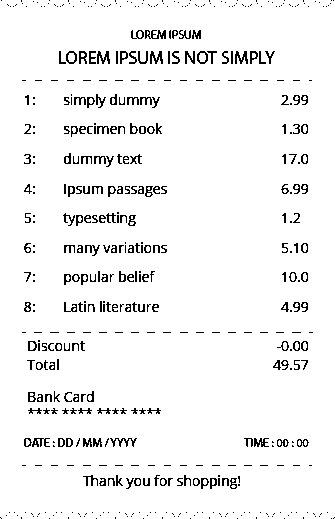

In [12]:
path_to_tesseract = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
img = Image.open('receipt.png')
#img.show()
display(img)

In [14]:
pytesseract.tesseract_cmd = path_to_tesseract
text = pytesseract.image_to_string(img)
print(text)

 

LOREM IPSUM
LOREM IPSUM IS NOT SIMPLY

 

 

simply dummy 2.99
2: specimen book 1.30
3: dummytext 17.0
4: Ipsum passages 6.99
5: typesetting 12
6: many variations 5.10
7: popular belief 10.0
8: Latin literature 499
“Discount -0.00
Total 49.57
Bank Card

  

Thank you for shopping!



### Method 2

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
#https://medium.com/analytics-vidhya/how-to-detect-tables-in-images-using-opencv-and-python-6a0f15e560c3
#https://towardsdatascience.com/a-table-detection-cell-recognition-and-text-extraction-algorithm-to-convert-tables-to-excel-files-902edcf289ec

In [3]:
file = r'receipt.png'
im1 = cv2.imread(file, 0)
im = cv2.imread(file)

In [5]:
im1,im

(array([[255,   0, 255, ..., 255,   0, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [  0, 255, 255, ..., 255, 255,   0],
        [255,   0, 255, ..., 255,   0, 255]], dtype=uint8),
 array([[[255, 255, 255],
         [  0,   0,   0],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [  0,   0,   0],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]

In [6]:
ret,thresh_value = cv2.threshold(im1,180,255,cv2.THRESH_BINARY_INV)

In [7]:
kernel = np.ones((5,5),np.uint8)
dilated_value = cv2.dilate(thresh_value,kernel,iterations = 1)

In [8]:
contours, hierarchy = cv2.findContours(dilated_value,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

In [10]:
cordinates = []
for cnt in contours:
 x,y,w,h = cv2.boundingRect(cnt)
 cordinates.append((x,y,w,h))
 #bounding the images
 if y< 50:
 
     cv2.rectangle(im,(x,y),(x+w,y+h),(0,0,255),1)

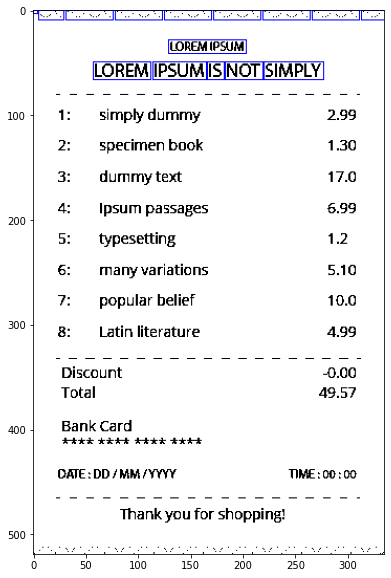

In [22]:
plt.figure(figsize = (25,10))
plt.imshow(im)
#cv2.namedWindow('detecttable', cv2.WINDOW_NORMAL)
#cv2.imwrite(‘detecttable.jpg’,im)